In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

In [44]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [45]:
DATASET_ID = 'swamp_sparrow'

In [46]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [47]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [85]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=100,
    mel_upper_edge_hertz=22000,
    butter_lowcut = 100,
    butter_highcut = 22000,
    ref_level_db = 25,
    min_level_db = -50,
    mask_spec = True,
    win_length_ms = 5,
    hop_length_ms = .5,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10}
)

In [86]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

In [87]:
dataset.sample_json

OrderedDict([('datetime', '2009-06-09_15-27-35'),
             ('samplerate_hz', 44100.0),
             ('indvs',
              OrderedDict([('NYMONT33',
                            OrderedDict([('syllables',
                                          OrderedDict([('start_time',
                                                        [0.101,
                                                         0.25,
                                                         0.55,
                                                         0.846,
                                                         1.138,
                                                         1.425,
                                                         1.714,
                                                         2.002,
                                                         2.305]),
                                                       ('end_time',
                                                        [0.21,
              

#### Create dataset based upon JSON

In [88]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 10

In [89]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=["syllable", "pos_in_syllable"],
            unit="elements",
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1974s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 330 ta

97573

In [90]:
syllable_df[:3]

,start_time,end_time,syllable,pos_in_syllable,indv,indvi,key
0,0.1015,0.1160,0.0,0.0,NYMONT33,0,SWSP09MONT33P1
1,0.1460,0.2095,0.0,1.0,NYMONT33,0,SWSP09MONT33P1
2,0.2510,0.2620,1.0,0.0,NYMONT33,0,SWSP09MONT33P1


In [ ]:
syllable_df

### get audio for dataset

In [91]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 265 tasks      | elapsed:  

97573

In [92]:
syllable_df[:3]

,start_time,end_time,syllable,pos_in_syllable,indv,indvi,key,audio,rate
0,0.1015,0.1160,0.0,0.0,NYMONT33,0,SWSP09MONT33P1,"[0.016902675631080007, 0.01836702934042918, 0....",44100
1,0.1460,0.2095,0.0,1.0,NYMONT33,0,SWSP09MONT33P1,"[0.024533612567214726, 0.012936161995261142, 0...",44100
2,0.2510,0.2620,1.0,0.0,NYMONT33,0,SWSP09MONT33P1,"[0.0022063292319460365, 0.013836752170883053, ...",44100


In [93]:
syllable_df.indvi.values[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [94]:
sylls = syllable_df.audio.values

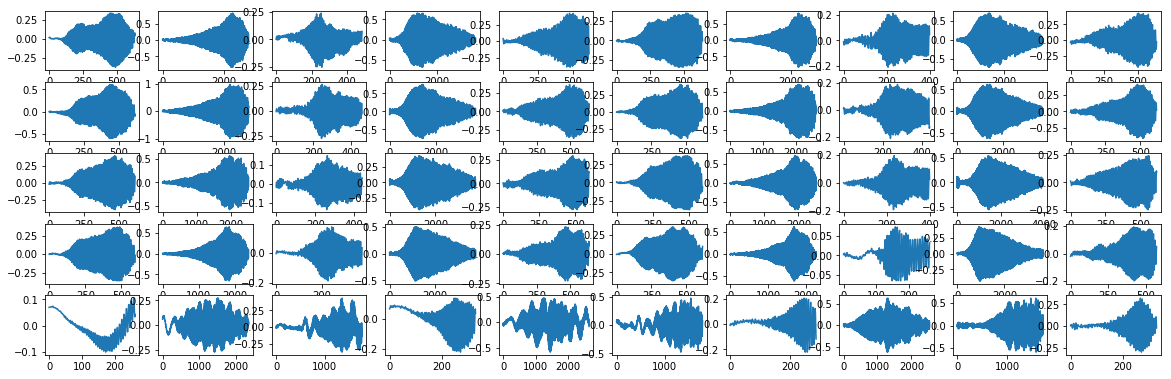

In [95]:
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

### Create spectrograms

In [96]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [97]:
syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values

In [98]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1852s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0532s.) Setting batch_size=14.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 162 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1477s.) Setting batch_size=36.
[Parallel(n_jobs=-1)]: Done 356 tasks      | elapsed

### Rescale spectrogram
- using log rescaling

In [99]:
log_scaling_factor = 4

In [100]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0710s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0549s.) Setting batch_size=28.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 116 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1276s.) Setting batch_size=86.
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1276 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2272 tasks      | elaps

(25.0, 10) (320, 800) 25.0 32 800


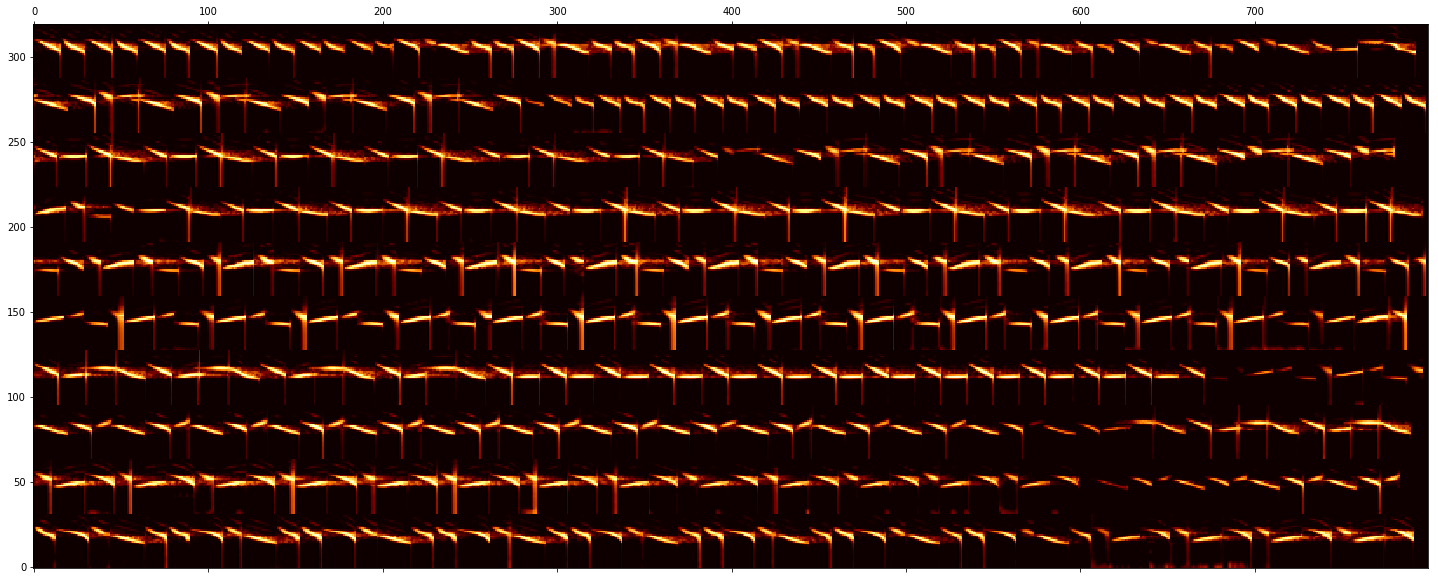

In [101]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

### Pad spectrograms

In [102]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

(array([1.0000e+00, 0.0000e+00, 6.0000e+01, 3.9140e+03, 1.5343e+04,
        1.9396e+04, 2.3140e+04, 2.1197e+04, 1.2493e+04, 2.0290e+03]),
 array([ 2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22.]),
 <a list of 10 Patch objects>)

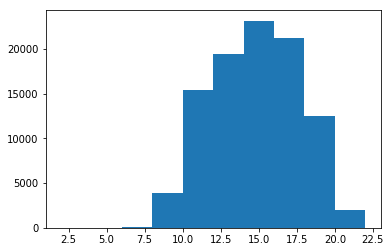

In [103]:
plt.hist(syll_lens)

In [104]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0093s.) Setting batch_size=42.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1559s.) Setting batch_size=106.
[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 762 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1392 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3972 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 5986 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 8000 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 10226 tasks      | elapsed:    1.4s
[Pa

(25.0, 10) (320, 800) 25.0 32 800


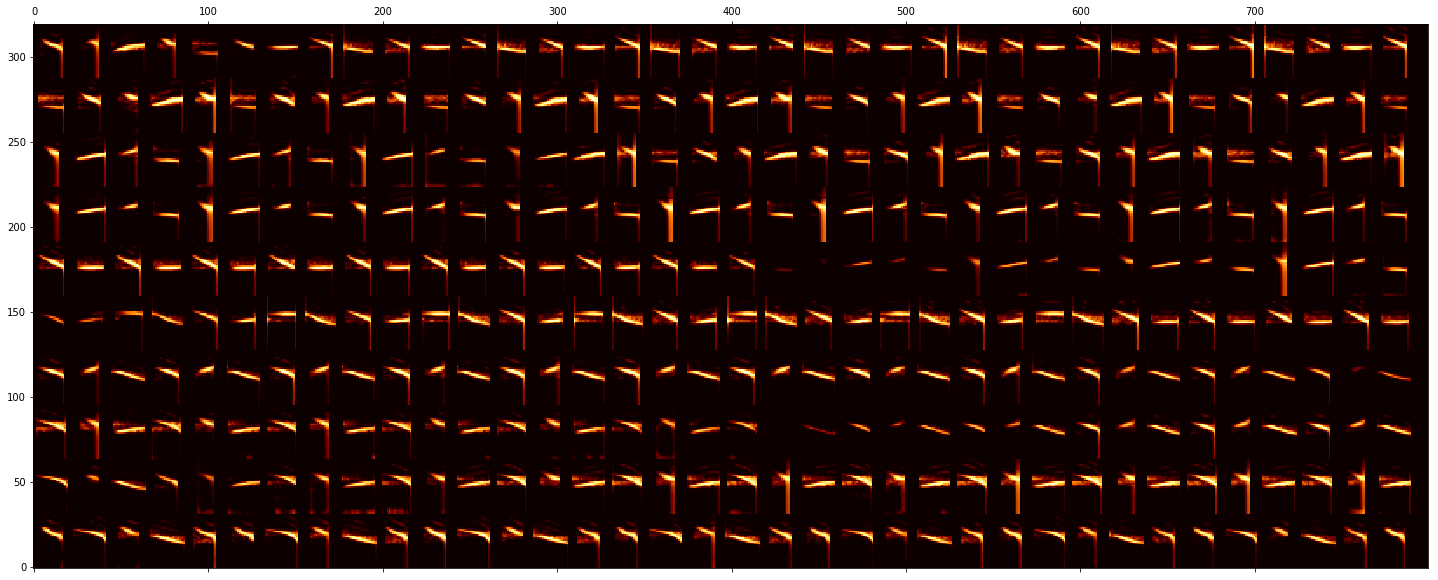

In [105]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

### save dataset

In [106]:
np.shape(syllables_spec)

(97573, 32, 22)

In [110]:
syllable_df[:3]

,start_time,end_time,syllable,pos_in_syllable,indv,indvi,key,audio,rate,spectrogram
0,0.1015,0.1160,0.0,0.0,NYMONT33,0,SWSP09MONT33P1,"[0.016902675631080007, 0.01836702934042918, 0....",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0.1460,0.2095,0.0,1.0,NYMONT33,0,SWSP09MONT33P1,"[0.024533612567214726, 0.012936161995261142, 0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,0.2510,0.2620,1.0,0.0,NYMONT33,0,SWSP09MONT33P1,"[0.0022063292319460365, 0.013836752170883053, ...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.056673408, 0.0122..."


In [107]:
syllable_df['spectrogram'] = syllables_spec

In [108]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'swampsparrow.pickle'
ensure_dir(save_loc)
syllable_df.to_pickle(save_loc)